In [7]:
# Numpy
import numpy as np
import pandas as pd
import scipy.stats, scipy.interpolate, scipy.spatial

# matplotlib
%matplotlib nbagg
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches

# plotly
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

# Machine learning
import tensorflow as tf
import keras
import sklearn
import sklearn.preprocessing, sklearn.base, sklearn.utils, sklearn.model_selection, sklearn.gaussian_process, sklearn.linear_model
import optunity
import statsmodels.nonparametric.smoothers_lowess

# Various Python tricks and libraries
import re
import requests
import time
import functools
import operator
import collections
from tqdm import tqdm, tqdm_notebook, tnrange
import dill as pickle
import IPython
import gc
import json
from collections import OrderedDict

# Parallel
import joblib
import multiprocessing
import pathos

In [8]:
plotly.offline.init_notebook_mode(connected=True)

In [9]:
class RnnIterator(object):
    '''
    Takes [(None, ...), (None, ...), (None, ...)] format data.
    Train-test split by train_index, test_index, train_split and/or test_split.
    Make batches.
    Executes n_epochs before raising StopIteration.
    Progress bar.
    
    Note: 
    "Train data" is preferred to "training data".
    
    Variables:
    train_data, test_data
    n_minibatches, i_minibatch
    n_epochs, @property i_epoch
    '''
    
    
    def __init__(self, data, minibatch_size, n_epochs, train_index=None, test_index=None, train_split=None, test_split=None, tqdm=True):
        self.minibatch_size = minibatch_size
        self.n_epochs = n_epochs
        N = len(data[0])
        all_index = range(N)
        
        # data shape consistency check
        data = [np.float32(_) for _ in data]
        assert len(np.unique([len(_) for _ in data])) == 1
        assert data[-1].ndim >= 2 # y is (None, 1), not (None)
        
        # determine train_index and test_index
        # given index
        if train_index and test_index:
            pass
        elif train_index and not test_index:
            test_index = list(set(all_index) - set(train_index))
        elif test_index and not train_index:
            train_index = list(set(all_index) - set(test_index))
        # given split percentage
        elif train_split and test_split:
            train_index = np.random.choice(all_index, int(N * train_split), replace=False)
            remaining_index = list(set(all_index) - set(train_index))
            test_index = np.random.choice(remaining_index, int(N * test_split), replace=False)
        elif train_split and not test_split:
            train_index = np.random.choice(all_index, int(N * train_split), replace=False)
            test_index = list(set(all_index) - set(train_index))
        elif test_split and not train_split:
            test_index = np.random.choice(all_index, int(N * test_split), replace=False)   
            train_index = list(set(all_index) - set(test_index))
        else:
            raise Exception("Either specify index, or specify split.") 
                            
        # generate train_data
        self.train_data = [_[train_index, ...] for _ in data]
        self.test_data = [_[test_index, ...] for _ in data]

        # minibatch counter
        self.i_minibatch = 0
        self.n_minibatches = n_epochs * len(self.train_data[0]) / minibatch_size
        
        if tqdm:
            self.tqdm = tqdm_notebook(total=self.n_minibatches, leave=False)
        
    def minibatch(self):
        if self.i_minibatch > self.n_minibatches:
            self.i_minibatch = 0
            raise StopIteration
        else:
            self.i_minibatch += 1
            
        if getattr(self, 'tqdm', None):
            self.tqdm.update(1)
        
        index = np.random.choice(range(len(self.train_data[0])), self.minibatch_size, replace=False)
        return [_[index, ...] for _ in self.train_data]
    
    @property
    def i_epoch(self):
        # the number of epochs
        return float(self.i_minibatch) * self.n_epochs / self.n_minibatches

In [10]:
class BetterYhatLive(object):
    '''
    Plot (i_epoch, r2).
    Plot (y, yhat).
    '''
    
    def __init__(self, smoothen):
        self.fig, (self.ax_decay, self.ax_corr) = plt.subplots(1, 2, figsize=(14, 4.2))
        self.ax_corr.set_aspect('equal', adjustable='datalim')
        self.i_epochs, self.line_decay_train, self.line_decay_test = [], [], []
        self.smoothen = smoothen
        
    def update(self, i_epoch, y_train, yhat_train, y_test, yhat_test):
        self.i_epochs.append(i_epoch)
        self.line_decay_train.append(sklearn.metrics.r2_score(y_train, yhat_train))
        self.line_decay_test.append(sklearn.metrics.r2_score(y_test, yhat_test))
        # smoothen
        if self.smoothen:
            x = range(len(self.line_decay_train))
            smoothline_decay_train = statsmodels.nonparametric.smoothers_lowess.lowess(self.line_decay_train, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
            smoothline_decay_test = statsmodels.nonparametric.smoothers_lowess.lowess(self.line_decay_test, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
        else:
            smoothline_decay_train = self.line_decay_train
            smoothline_decay_test = self.line_decay_test
        #
        label_train = '$r^2_{train}$=%.2f'%self.line_decay_train[-1]
        label_test = '$r^2_{test}$=%.2f'%self.line_decay_test[-1]
        #
        self.ax_decay.clear()
        self.ax_decay.plot(self.i_epochs, smoothline_decay_train, label=label_train)
        self.ax_decay.plot(self.i_epochs, smoothline_decay_test, label=label_test)
        self.ax_decay.legend(loc='best')
        #
        self.ax_corr.clear()
        self.ax_corr.set_aspect('equal', adjustable='datalim')
        self.ax_corr.scatter(y_train, yhat_train, color='green', s=1, alpha=0.2, label='train')
        self.ax_corr.scatter(y_test, yhat_test, color='red', s=1, alpha=0.2, label='test')
        self.ax_corr.legend(loc='best')
        #
        self.fig.canvas.draw()

In [11]:
class LambdaGraph(object):
    
    def __init__(self):
        self.bs = OrderedDict()
        
    def add(self, b, label): # b is a BetterYhatLive instance
        if label in self.bs:
            raise Exception("label %s already in self.bs" %label)
        self.bs[label] = np.float32(zip(b.i_epochs, b.line_decay_train, b.line_decay_test))
        
    def draw(self):
        print """
        traces = [
            go.Scatter(x = b[:, 1], y = b[:, 2], mode = 'markers', name = label)
            for label, b in l.bs.iteritems()
        ]
        py.iplot(traces, filename='threshold_errors')"""

In [12]:
# Boilerplate for plotting a dataframe. Do not attempt a function.
# data = [
#     go.Scatter(x = df.index, y = df.loc[:, column], mode = 'markers+lines', name = column) 
#     for column in df.columns
# ]
# py.iplot(data, filename='threshold_errors')   

In [13]:
class RnnStandardScaler():
    '''
    StandardScaler, but for RNN-style input, i.e. None * Irregular * Nfeatures.
    
    Unlike LabelEncoder, sometimes StandardScaler'ing the original DataFrame is not possible.
    
    Supports neither *args nor **kwargs.
    '''
    
    def __init__(self, processes=20):
        self.processes = processes
        self.scaler = sklearn.preprocessing.StandardScaler()
        
    def fit(self, X):
        assert isinstance(X[0][0][0], float)
        
        X_ = np.concatenate(X, axis=0)
        assert not np.isnan(X_).any()
        self.scaler.fit(X_)
        
        return self
    
    def transform(self, X):
        assert isinstance(X[0][0][0], float)
        
        if self.processes:
            return pathos.multiprocessing.ProcessPool(nodes=self.processes).map(lambda _: list(self.scaler.transform(_)), X)
        else:
            return map(lambda _: list(self.scaler.transform(_)), X)
        
    def fit_transform(self, X):
        return self.fit(X).transform(X)
        

# 准备$\left\{\text{eta}_j, \text{nodes}_j, j\in Q\,\middle|\,j\in L\cup Q\right\}$

读logfile，使之compatible with逻辑定义。

In [15]:
def read_log():
    jobs = pd.read_csv(filepath_or_buffer='ml_queue.nanaimo.20170101-20180704.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown']).dropna()

    jobs.loc[:, 'nodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')
    
    # job_name not implemented

    jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
    jobs.loc[:, 'eta'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce') / pd.Timedelta('1day')

    jobs.loc[:, 'submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
    
    jobs.loc[:, 'begin'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
    
    jobs.loc[:, 'end'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')
    
    jobs.loc[:, 'user'] = jobs.loc[:, 'User'].copy() # uid not implemented
    
    # subfile not implemented
    
    jobs.loc[:, 'state'] = jobs.loc[:, 'State'].copy() # scancelled not implemented
    
    jobs.loc[:, 'wait'] = (jobs.begin - jobs.submit).values / pd.Timedelta('1h')

    jobs = jobs.dropna()
    
    jobs = jobs.drop(columns=['User', 'NNodes', 'Timelimit', 'Submit', 'Start', 'End', 'State'])
    
    return jobs

In [16]:
jobs = read_log()

准备剔除should_not_wait.

In [17]:
def SQ(i):
    # S: in service. Q: wait queue.
    
    if i < 100:
        raise Exception
    
    j = jobs.loc[i]
    
    S = jobs.loc[
        np.logical_and.reduce([
            jobs.begin < j.submit, 
            jobs.end >= j.submit
        ])
    ]
    
    Q = jobs.loc[
        np.logical_and.reduce([
            jobs.submit < j.submit, 
            jobs.begin >= j.submit
        ])
    ]
    
    return S.copy(), Q.copy()

In [18]:
def should_not_wait(i, C):
    S, Q = SQ(i)
    return S.nodes.sum() + Q.nodes.sum() + jobs.loc[i].nodes <= C

C = 32

valid_indices = [_ for _ in jobs.index if _>100]

array_should_not_wait = multiprocessing.Pool(processes=20).map(
    functools.partial(should_not_wait, C=C),
    valid_indices
)
jobs.loc[valid_indices, 'should_not_wait'] = array_should_not_wait

Process PoolWorker-15:
Process PoolWorker-6:
Process PoolWorker-18:
Traceback (most recent call last):
Process PoolWorker-20:
Process PoolWorker-16:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-17:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-14:
Traceback (most recent call last):
Process PoolWorker-10:
Process PoolWorker-9:
Process PoolWorker-5:
Process PoolWorker-13:
    self.run()
    self.run()
Process PoolWorker-4:
Process PoolWorker-19:
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
Trac

    racquire()
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    task = get()
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    racquire()
KeyboardInterrupt
KeyboardInterrupt
    racquire()
KeyboardInterrupt
    racquire()
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
    racquire()
    

取有意义的（如：CANCELLED+，should_not_wait，<100）sample.

In [19]:
def feature(i):
    
    if i <= 100:
        raise Exception
        
    if jobs.loc[i, 'should_not_wait']:
        return None
    
    if jobs.loc[i, 'state'] == 'CANCELLED+':
        return None  
    
    S, Q = SQ(i)
    S['in_Q'] = 0
    Q['in_Q'] = 1
    
    J = jobs.loc[i:i].copy()
    J['in_Q'] = 2
    
    SQJ = pd.concat([S, Q, J])
    
    return SQJ.loc[:, ['eta', 'nodes', 'in_Q']].values

In [20]:
def label(i):
    
    if i <= 100:
        raise Exception
        
    if jobs.loc[i, 'should_not_wait']:
        return None
    
    if jobs.loc[i, 'state'] == 'CANCELLED+':
        return None  
    
    return jobs.loc[i, 'wait']

In [21]:
valid_indices = [_ for _ in jobs.index if _ > 100]

features = pathos.multiprocessing.ProcessPool(nodes=20).map(feature, valid_indices)
features = [_ for _ in features if _ is not None]

labels = pathos.multiprocessing.ProcessPool(nodes=20).map(label, valid_indices)
labels = [_ for _ in labels if _ is not None]
assert len(labels) == len(features)

Process PoolWorker-15:
Process PoolWorker-20:
Process PoolWorker-1:
Process PoolWorker-11:
Traceback (most recent call last):
Process PoolWorker-5:
Process PoolWorker-12:
Process PoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-19:
Process PoolWorker-9:
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/process.py", line 267, in _bootstrap
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/process.py", line 267, in _bootstrap
Process PoolWorker-6:
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/process.py", line 267, in _bootstrap
Process PoolWorker-17:
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/process.py", line 267, in _bootstrap
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/process.py", line 267, in _bootstrap
  File "/usr/local/lib/python2.7/dist-packages/multiproce

    self._target(*self._args, **self._kwargs)
    task = get()
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/queues.py", line 377, in get
    racquire()
    self._target(*self._args, **self._kwargs)
    return recv()
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/pool.py", line 102, in worker
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/process.py", line 114, in run
    racquire()
KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/queues.py", line 377, in get
KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)
    task = get()
    racquire()
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/queues.py", line 377, in get
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/pool.py", line 102, in worker
KeyboardInterrupt
  File "/usr/local/l

没有outlier（从wait意义上，和从队列长度意义上）。注意数据类型已经是ndarray.

In [22]:
p = np.percentile(labels, q=95)
outlier_indices_wait = np.argwhere(labels > p).reshape(-1)

lens = [len(_) for _ in features]
p = np.percentile(lens, q=95)
outlier_indices_lens = np.argwhere(lens > p).reshape(-1)

outlier_indices = set(outlier_indices_wait) | set(outlier_indices_lens)

features = [features[_] for _ in range(len(features)) if _ not in outlier_indices]
labels = [labels[_] for _ in range(len(labels)) if _ not in outlier_indices]

服从$\mu(0,1)$.

In [23]:
features = RnnStandardScaler(processes=20).fit_transform(features)

程序层面的技术细节。

In [24]:
labels = np.array(labels).reshape(-1, 1)

In [25]:
lengths = [len(_) for _ in features]
lengths = np.array(lengths)

In [26]:
features = keras.preprocessing.sequence.pad_sequences(features, maxlen=None, dtype='float', padding='post')

# RNN

In [27]:
# l = LambdaGraph()
with open("temp.pickle", "rb") as f:
    l = pickle.load(f)

HBox(children=(IntProgress(value=0, max=84375), HTML(value=u'')))

<IPython.core.display.Javascript object>


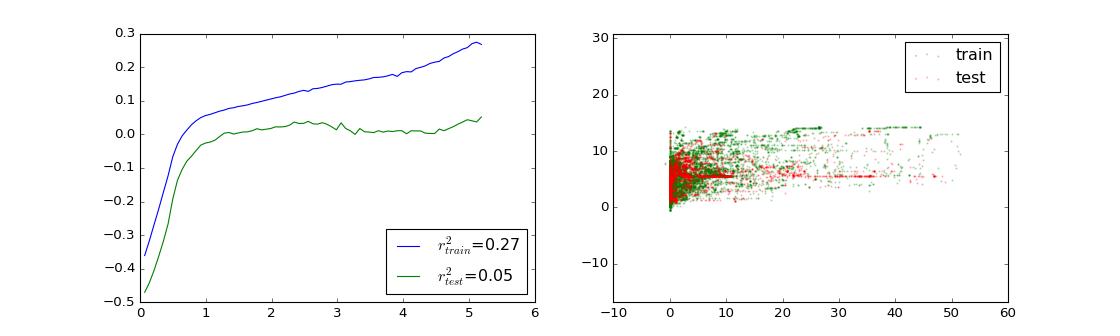

In [ ]:
minibatch_size = 32
n_epochs = 300
ns_rnn_units = [5, 5]
ns_dense_units = [5]
lr = 1E-3

i = RnnIterator(data = [features, lengths, labels], minibatch_size = minibatch_size, n_epochs = n_epochs, train_index = range(9000), test_index = range(9000,12000))
b = BetterYhatLive(smoothen = False)

# Graph
tf.reset_default_graph()

fe = tf.placeholder(name="features", dtype=tf.float32, shape=[None, features.shape[1], features.shape[2]])
le = tf.placeholder(name="lengths", dtype=tf.int32, shape=[None])
la = tf.placeholder(name="labels", dtype=tf.float32, shape=[None, labels.shape[1]])

hs, h = tf.nn.dynamic_rnn(
    tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(n) for n in ns_rnn_units]),
    fe,
    dtype = tf.float32,
    sequence_length = le
)
h = h[-1]

for n in ns_dense_units:
    h = tf.layers.dense(h, units=n, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
lahat = h

loss = tf.reduce_mean(tf.square(lahat - la), keepdims=False)
training_op = tf.train.AdamOptimizer(lr).minimize(loss)

# Session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

while True:
    try:
        feat, lent, labe = i.minibatch()
        sess.run(training_op, feed_dict={fe: feat, le: lent, la: labe})
        
        if i.i_minibatch % 20 == 0:
            feat_train, lent_train, labe_train = i.train_data
            labehat_train = sess.run(lahat, feed_dict={fe: feat_train, le: lent_train})

            feat_test, lent_test, labe_test = i.test_data
            labehat_test = sess.run(lahat, feed_dict={fe: feat_test, le: lent_test})

            b.update(i.i_epoch, labe_train, labehat_train, labe_test, labehat_test)
    except StopIteration:
        break       

sess.close()

In [46]:
l.add(b, label='5~5-5 GRU, Adam 0.001, mb16')

In [47]:
traces = [
    go.Scatter(x = b[:, 1], y = b[:, 2], mode = 'markers', name = label)
    for label, b in l.bs.iteritems()
]
py.iplot(traces, filename='ml_queue_0824.sec2.fig1.temp')

In [48]:
with open("temp.pickle", "wb") as f:
    pickle.dump(l, f)

# Trash

In [36]:
l.bs["5~5-5, Adam 0.001, mb256"] = arr[np.argwhere(arr[:,2] > -0.1).reshape(-1)]